In [239]:
import glob
import gensim
import pandas as pd
import numpy as np
import logging
import nltk
import itertools
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [240]:
keyword = pd.read_csv("keyword.csv", names=['keyword'])

D_raw = [keyword.keyword.tolist()]
VECTOR_LEN = len(D_raw[0])

D = gensim.corpora.Dictionary(D_raw)

D.items()[:5]

2017-07-28 17:59:30,941 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-28 17:59:30,941 : INFO : built Dictionary(21 unique tokens: [u'sell', u'plant', u'buy', u'layoff', u'deal']...) from 1 documents (total 21 corpus positions)


[(0, u'sell'), (1, u'plant'), (2, u'buy'), (14, u'layoff'), (4, u'deal')]

In [241]:
files = [('data/layoff.csv', 1), ("data_clf/health_reuter.csv", 0)] # (file, label)

data_ = []
for f, label in files:
    print 'Reading', f
    df = pd.read_csv(f)
    df['full_content'] = df['title'] + ' ' + df['long_text']
    df['label'] = label
    data_.append(df)
    
data = pd.concat(data_)
data.head()

Reading data/layoff.csv
Reading data_clf/health_reuter.csv


,url,title,tag,time,short_text,long_text,full_content,label
0,https://www.reuters.com/article/brief-soundclo...,BRIEF-SoundCloud says to layoff 173 employees ...,NaN,"July 6, 2017 / 4:09 PM / 21 days ago",NaN,July 6 (Reuters) - * SoundCloud says took the ...,BRIEF-SoundCloud says to layoff 173 employees ...,1
1,https://www.reuters.com/article/americanappare...,American Apparel starts layoffs -sources,NaN,"January 16, 2017 / 5:49 PM / in 6 months",NaN,Jan 16 (Reuters) - American Apparel LLC starte...,American Apparel starts layoffs -sources Jan 1...,1
2,https://www.reuters.com/article/idUSL5N1FD0MP,BRIEF-Alma Market to layoff 425 employees,NaN,"January 23, 2017 / 6:20 AM / 6 months ago",NaN,Jan 23 (Reuters) - Alma Market SA : * Said on ...,BRIEF-Alma Market to layoff 425 employees Jan ...,1
3,https://www.reuters.com/article/usa-economy-la...,U.S. planned layoffs slow in June: Challenger,NaN,"July 6, 2017 / 11:43 AM / 21 days ago",NaN,(Reuters) - The number of planned layoffs at U...,U.S. planned layoffs slow in June: Challenger ...,1
4,https://www.reuters.com/article/us-usa-economy...,U.S. planned layoffs slow in June: Challenger,NaN,"July 6, 2017 / 11:43 AM / 21 days ago",NaN,(Reuters) - The number of planned layoffs at U...,U.S. planned layoffs slow in June: Challenger ...,1


In [242]:
def line2vec(doc, dictionary):
    doc = [wordnet_lemmatizer.lemmatize(z) for z in tokenizer.tokenize(str(doc).decode('utf-8').lower()) if z not in STOPWORDS] 
    bow_vector = dictionary.doc2bow(doc)
    
    # Convert to multi-hot vector
    bow_vector = [(v, 1) for v, _ in bow_vector]
    
    return bow_vector 

def doc2vec(data_texts):
    return [line2vec(text, D) for text in data_texts]

def similarity(text):
    vector = line2vec(text, D)
    baseline_vector = gensim.matutils.dense2vec(np.ones(VECTOR_LEN))
    
    return gensim.matutils.cossim(vector, baseline_vector)

def predict(sim, threshold = 0.45):
    return 1 if sim >= threshold else 0

In [243]:
THRESHOLD = 0.45

data['similarity'] = data['full_content'].apply(similarity)
data['predict'] = data['similarity'].apply(lambda t: predict(t, THRESHOLD))

In [244]:
data

,url,title,tag,time,short_text,long_text,full_content,label,similarity,predict
0,https://www.reuters.com/article/brief-soundclo...,BRIEF-SoundCloud says to layoff 173 employees ...,NaN,"July 6, 2017 / 4:09 PM / 21 days ago",NaN,July 6 (Reuters) - * SoundCloud says took the ...,BRIEF-SoundCloud says to layoff 173 employees ...,1,0.436436,0
1,https://www.reuters.com/article/americanappare...,American Apparel starts layoffs -sources,NaN,"January 16, 2017 / 5:49 PM / in 6 months",NaN,Jan 16 (Reuters) - American Apparel LLC starte...,American Apparel starts layoffs -sources Jan 1...,1,0.577350,1
2,https://www.reuters.com/article/idUSL5N1FD0MP,BRIEF-Alma Market to layoff 425 employees,NaN,"January 23, 2017 / 6:20 AM / 6 months ago",NaN,Jan 23 (Reuters) - Alma Market SA : * Said on ...,BRIEF-Alma Market to layoff 425 employees Jan ...,1,0.436436,0
3,https://www.reuters.com/article/usa-economy-la...,U.S. planned layoffs slow in June: Challenger,NaN,"July 6, 2017 / 11:43 AM / 21 days ago",NaN,(Reuters) - The number of planned layoffs at U...,U.S. planned layoffs slow in June: Challenger ...,1,0.577350,1
4,https://www.reuters.com/article/us-usa-economy...,U.S. planned layoffs slow in June: Challenger,NaN,"July 6, 2017 / 11:43 AM / 21 days ago",NaN,(Reuters) - The number of planned layoffs at U...,U.S. planned layoffs slow in June: Challenger ...,1,0.577350,1
5,https://www.reuters.com/article/gm-layoffs-idU...,"GM will layoff 1,100 in Michigan after product...",NaN,"March 6, 2017 / 3:11 PM / 5 months ago",NaN,"WASHINGTON, March 6 (Reuters) - General Motors...","GM will layoff 1,100 in Michigan after product...",1,0.534522,1
6,https://www.reuters.com/article/employment-sey...,"Seyfarth Shaw announces layoffs, cites 'shifti...",NaN,"May 17, 2017 / 9:06 PM / 2 months ago",NaN,"Seyfarth Shaw, one of the largest U.S. labor a...","Seyfarth Shaw announces layoffs, cites 'shifti...",1,0.218218,0
7,https://www.reuters.com/article/idUSFWN1F70Y3,"BRIEF-Lowe's Companies to layoff about 2,400 e...",NaN,"January 18, 2017 / 1:31 AM / 6 months ago",NaN,Jan 17 (Reuters) - Lowe's Companies Inc * Smal...,"BRIEF-Lowe's Companies to layoff about 2,400 e...",1,0.436436,0
8,https://www.reuters.com/article/us-alpineskiin...,Vonn wins in second race after injury layoff,NaN,"January 21, 2017 / 1:12 PM / 6 months ago",NaN,BERLIN (Reuters) - Irrepressible Lindsey Vonn ...,Vonn wins in second race after injury layoff B...,1,0.218218,0
9,https://www.reuters.com/article/espn-layoffs-i...,ESPN to layoff 100 on-air talent: source,NaN,"April 26, 2017 / 2:57 PM / in 3 months",NaN,(Reuters) - Walt Disney Co 's ESPN television ...,ESPN to layoff 100 on-air talent: source (Reut...,1,0.487950,1


In [245]:
print '(label == 1)', len(data[data.label == 1])
print 'max similarity of (label == 1)', max(data[data.label == 1].similarity)
print 'min similarity of (label == 1)', min(data[data.label == 1].similarity)

data_1 = data[data.label == 1]
print '(label == 1) and similarity >= THRESHOLD', len(data_1[data_1.similarity >= THRESHOLD])
print '(label == 1) and similarity > THRESHOLD', len(data_1[data_1.similarity < THRESHOLD])


print 


print '(label == 0)', len(data[data.label == 0])
print 'max similarity of (label == 0)', max(data[data.label == 0].similarity)
print 'min similarity of (label == 0)', min(data[data.label == 0].similarity)

data_0 = data[data.label == 0]
print '(label == 0) and similarity >= THRESHOLD', len(data_0[data_0.similarity >= THRESHOLD])
print '(label == 0) and similarity < THRESHOLD', len(data_0[data_0.similarity < THRESHOLD])

(label == 1) 856
max similarity of (label == 1) 0.845154254729
min similarity of (label == 1) 0.0
(label == 1) and similarity >= THRESHOLD 496
(label == 1) and similarity > THRESHOLD 360

(label == 0) 139
max similarity of (label == 0) 0.654653670708
min similarity of (label == 0) 0.0
(label == 0) and similarity >= THRESHOLD 9
(label == 0) and similarity < THRESHOLD 130


In [246]:
from sklearn.metrics import confusion_matrix
y_true = data.label.tolist()
y_pred = data.predict.tolist()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[130,   9],
       [360, 496]])

In [247]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[130   9]
 [360 496]]


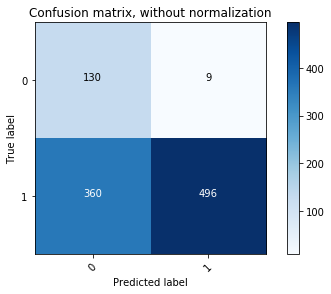

In [248]:
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [231]:
data_ = data

In [232]:
post_predicted = data[data.predict == 1]
post_predicted

data = post_predicted

# remove common words and tokenize
data['full_content'] = data['title'] + ' ' + data['long_text']
full_content = data['full_content'].tolist()
full_content = [[wordnet_lemmatizer.lemmatize(z) for z in tokenizer.tokenize(str(t).decode('utf-8').lower()) if z not in STOPWORDS] for t in full_content]
# full_content = [[z for z in str(t).lower().split(" ") if z not in STOPWORDS] for t in full_content]
print full_content[:2]
with open("full_content", "wb") as f:
    f.write(str(full_content))
    
# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in full_content:
    for token in text:
        frequency[token] += 1

# full_content = [[token for token in text if frequency[token] > 1] for text in full_content]
print full_content[:2]

dictionary = gensim.corpora.Dictionary(full_content)
corpus = [dictionary.doc2bow(text) for text in full_content]

NUM_TOPICS = 10
NUM_TERMS = 100
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                      num_topics=NUM_TOPICS, update_every=1, 
                                      chunksize=10000, passes=1)

# select top 100 words for each of the 10 LDA topics
TOP_KEYWORDS = [[word for word, _ in lda.show_topic(topicno, topn=NUM_TERMS)]
             for topicno in range(lda.num_topics)]
print(TOP_KEYWORDS[:3])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
2017-07-28 17:50:20,802 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


[[u'american', u'apparel', u'start', u'layoff', u'source', u'jan', u'16', u'reuters', u'american', u'apparel', u'llc', u'started', u'lay', u'staff', u'monday', u'canada', u'gildan', u'activewear', u'inc', u'withdrew', u'initial', u'plan', u'buy', u'bankrupt', u'u', u'fashion', u'retailer', u'manufacturing', u'operation', u'people', u'familiar', u'matter', u'said', u'gildan', u'right', u'american', u'apparel', u'brand', u'88', u'million', u'bid', u'bankruptcy', u'auction', u'last', u'week', u'previously', u'indicated', u'would', u'assume', u'manufacturing', u'operation', u'made', u'brand', u'synonymous', u'made', u'u', u'many', u'2', u'166', u'employee', u'company', u'headquarters', u'los', u'angeles', u'959', u'employee', u'nearby', u'south', u'gate', u'manufacturing', u'facility', u'stand', u'lose', u'job', u'source', u'said', u'asking', u'identified', u'disclosing', u'detail', u'medium', u'company', u'issued', u'warn', u'act', u'notice', u'several', u'month', u'ago', u'letting', u'em

2017-07-28 17:50:20,957 : INFO : built Dictionary(10695 unique tokens: [u'2g4ixny', u'four', u'francesco', u'francesca', u'trawling']...) from 552 documents (total 164994 corpus positions)
2017-07-28 17:50:21,098 : INFO : using symmetric alpha at 0.1
2017-07-28 17:50:21,099 : INFO : using symmetric eta at 9.35016362786e-05
2017-07-28 17:50:21,101 : INFO : using serial LDA version on this node
2017-07-28 17:50:22,134 : INFO : running online LDA training, 10 topics, 1 passes over the supplied corpus of 552 documents, updating model once every 552 documents, evaluating perplexity every 552 documents, iterating 50x with a convergence threshold of 0.001000
2017-07-28 17:50:22,135 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-07-28 17:50:27,756 : INFO : -10.594 per-word bound, 1545.2 perplexity estimate based on a held-out corpus of 552 documents with 164994 words
2017-07-28 17:50:27,757 : INFO : PROG

[[u'said', u'layoff', u'job', u'cut', u'percent', u'month', u'state', u'company', u'worker', u'year', u'000', u'u', u'new', u'1', u'employee', u'last', u'week', u'announced', u'2', u'would', u'billion', u'government', u'market', u'since', u'labor', u'also', u'reuters', u'oil', u'bank', u'union', u'report', u'editing', u'plant', u'plan', u'city', u'sector', u'could', u'3', u'cost', u'5', u'first', u'firm', u'sale', u'reporting', u'business', u'york', u'one', u'rate', u'two', u'quarter', u'million', u'time', u'day', u'data', u'may', u'industry', u'march', u'people', u'fund', u'claim', u'level', u'euro', u'4', u'revenue', u'thursday', u'staff', u'end', u'budget', u'deal', u'8', u'according', u'planned', u'500', u'still', u'unemployment', u'price', u'number', u'7', u'challenger', u'expected', u'chief', u'official', u'department', u'june', u'tax', u'january', u'inc', u'workforce', u'say', u'financial', u'growth', u'spending', u'low', u'production', u'three', u'employment', u'largest', u'ben

In [236]:
# Export 
n = 0
combined = []
for _ in TOP_KEYWORDS:
    combined += _

combined_df = pd.DataFrame(combined)
combined_df = pd.DataFrame(combined_df[0].value_counts().sort_values()).reset_index()
combined_df.columns = ['keyword', 'c']

keyword_in_predicted = combined_df.keyword.tolist()

In [237]:
for k in keyword.keyword.tolist():
    if k in keyword_in_predicted:
        print k

growth
board
plant
equity
plan
sale
million
percent
new
rate
cost
share
financial
worker
bank
fund
layoff
price
business
cut
deal
investment
announced
job
employee
labor
union
market


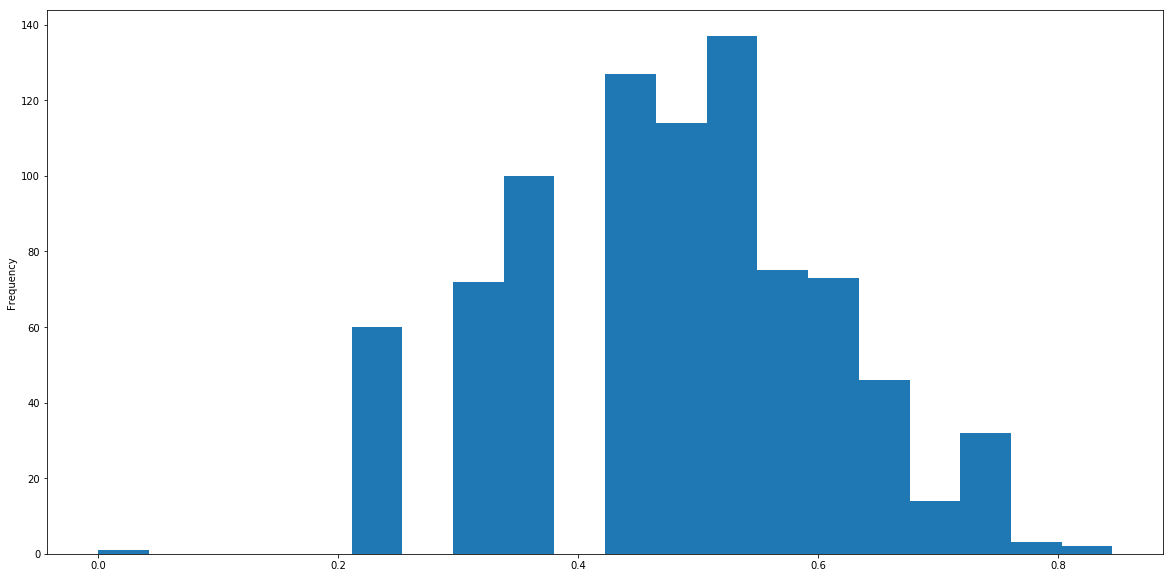

In [249]:
%matplotlib inline
import matplotlib as plt

data[data.label == 1].similarity.plot.hist(figsize=(20,10), bins=20)

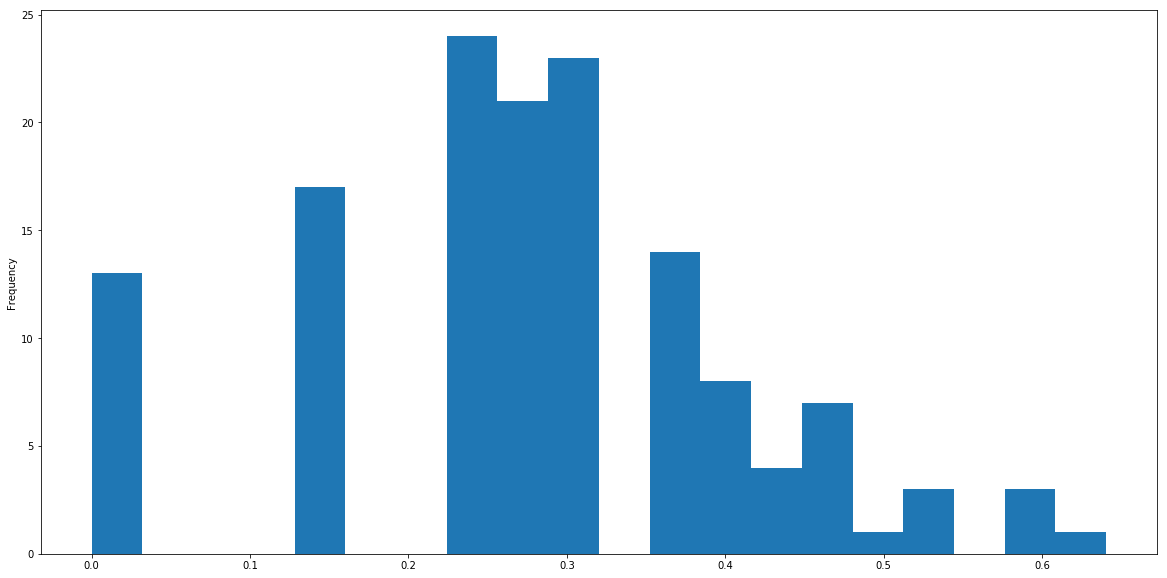

In [194]:
data[data.label == 0].similarity.plot.hist(figsize=(20,10), bins=20)

<Container object of 10 artists>

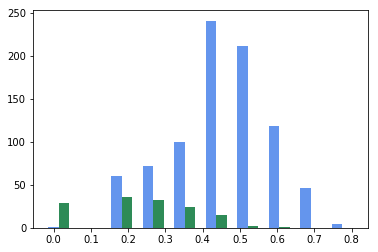

In [250]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
#import seaborn
#seaborn.set(style='ticks')

np.random.seed(0)
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(data[data.label == 1].similarity)
b_heights, b_bins = np.histogram(data[data.label == 0].similarity, bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

In [251]:
THRESHOLD = 0.6
data_0[data_0.similarity >= THRESHOLD].title.tolist()

['As drug prices drop, generics makers fight back with deals']

In [202]:
THRESHOLD = 0.25
data_1[data_1.similarity < THRESHOLD].title.tolist()

['Vonn wins in second race after injury layoff',
 'Federer expects injury layoff to prolong playing career',
 'BRIEF-Hanjin Shipping sends layoff notices effective Dec. 10 to 560 crew members- Nikkei',
 'Sony Pictures to announce layoffs across divisions -source',
 'Dow accidentally released layoffs news early: source',
 'Dow accidentally released layoffs news early: source',
 'Dow accidentally released layoffs news early - source',
 'Twitter plans layoffs next week - Re/code',
 'Sharapova delights at gutsy win on return from layoff',
 'Layoffs hit Goodwin Procter amid decline in litigation',
 'Richards-Ross to make comeback after injury layoff',
 'BRIEF-AMD planning significant layoffs following recent revenue warning - source',
 "Athletics: Defar runs year's fastest 3,000 meter after long layoff",
 'Female truck driver can sue over layoff - 3rd Circuit',
 'Masters thumbs up for Australian Day after injury layoff',
 'Brazil state banks face reality check as downturn sparks layoffs',
 